In [1]:
import torch
from model.base import BaseModule
from model.utils import sequence_mask, convert_pad_shape
import math
from model.text_encoder import LayerNorm, ConvReluNorm, MultiHeadAttention, FFN, Encoder, DurationPredictor

In [2]:
from configs.params_v0 import (cmudict_path,
                               train_filelist_path,
                               reorder_feats
                               )
from data import TextArticDataset, TextArticBatchCollate

train_dataset = TextArticDataset(
    filelist_path=train_filelist_path,
    cmudict_path=cmudict_path,
    add_blank=True,
)

for i,e in enumerate(train_dataset.filepaths_and_text):
    if "LJ033-0001.wav" in e[0]:
        print("found")
        fp_and_txt = e
        idx = i
(text, art) = train_dataset.get_pair(fp_and_txt, from_preprocessed=True)
print(text.shape, art.shape)
batch = [train_dataset[idx]]

collate_fn = TextArticBatchCollate()
batch = collate_fn(batch)

/home/anli/Desktop/art-tts/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anli/Desktop/art-tts/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


found
torch.Size([25, 168]) torch.Size([16, 486])


In [3]:
class TextEncoder(BaseModule):
    def __init__(
        self,
        n_ipa_feats,
        n_feats,
        n_channels,
        filter_channels,
        filter_channels_dp,
        n_heads,
        n_layers,
        kernel_size,
        p_dropout,
        window_size=None,
        spk_emb_dim=64,
        n_spks=1,
    ):
        super(TextEncoder, self).__init__()
        self.n_ipa_feats = n_ipa_feats
        self.n_feats = n_feats
        self.n_channels = n_channels
        self.filter_channels = filter_channels
        self.filter_channels_dp = filter_channels_dp
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.p_dropout = p_dropout
        self.window_size = window_size
        self.spk_emb_dim = spk_emb_dim
        self.n_spks = n_spks

        #self.emb = torch.nn.Embedding(n_vocab, n_channels)
        #torch.nn.init.normal_(self.emb.weight, 0.0, n_channels**-0.5)

        self.prenet = ConvReluNorm(
            n_ipa_feats, n_channels, n_ipa_feats, kernel_size=5, n_layers=3, p_dropout=0.5
        )

        self.encoder = Encoder(
            n_ipa_feats + (spk_emb_dim if n_spks > 1 else 0),
            filter_channels,
            n_heads,
            n_layers,
            kernel_size,
            p_dropout,
            window_size=window_size,
        )

        self.proj_m = torch.nn.Conv1d(
            n_ipa_feats + (spk_emb_dim if n_spks > 1 else 0), n_feats, 1
        )
        self.proj_w = DurationPredictor(
            n_ipa_feats + (spk_emb_dim if n_spks > 1 else 0),
            filter_channels_dp,
            kernel_size,
            p_dropout,
        )

    def forward(self, x, x_lengths, spk=None):
        #x = self.emb(x) * math.sqrt(self.n_channels)  # shape: (B, T, C)
        #x = torch.transpose(x, 1, -1)  # shape: (B, C, T)
        x_mask = torch.unsqueeze(sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)   # shape: (B, 1, T)
        print("x_mask", x_mask.shape)
        x = self.prenet(x, x_mask)
        print("x post prenet", x.shape)
        if self.n_spks > 1:
            x = torch.cat([x, spk.unsqueeze(-1).repeat(1, 1, x.shape[-1])], dim=1)
        x = self.encoder(x, x_mask)
        print("x post encoder", x.shape)
        mu = self.proj_m(x) * x_mask
        print("mu post proj_m", mu.shape)
        x_dp = torch.detach(x)
        logw = self.proj_w(x_dp, x_mask)
        print("logw post proj_w", logw.shape)
        return mu, logw, x_mask

In [4]:
n_ipa_feats = 25
n_feats = 14
n_enc_channels = 192
filter_channels = 768
filter_channels_dp = 256
n_enc_layers = 6
enc_kernel = 3
enc_dropout = 0.1
n_heads = 1
window_size = 4

encoder = TextEncoder(
    n_ipa_feats=n_ipa_feats,
    n_feats=n_feats,
    n_channels=n_enc_channels,
    filter_channels=filter_channels,
    filter_channels_dp=filter_channels_dp,
    n_heads=n_heads,
    n_layers=n_enc_layers,
    kernel_size=enc_kernel,
    p_dropout=enc_dropout,
)

In [5]:
prenet = ConvReluNorm(
            n_ipa_feats, n_enc_channels, n_ipa_feats, kernel_size=5, n_layers=3, p_dropout=0.5
        )


In [6]:
x, x_lengths = batch["x"], batch["x_lengths"]
x_mask = torch.unsqueeze(sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)

In [7]:
mu, logw, x_mask = encoder(batch["x"], batch["x_lengths"])

x_mask torch.Size([1, 1, 168])
x post prenet torch.Size([1, 25, 168])


x post encoder torch.Size([1, 25, 168])
mu post proj_m torch.Size([1, 14, 168])
logw post proj_w torch.Size([1, 1, 168])


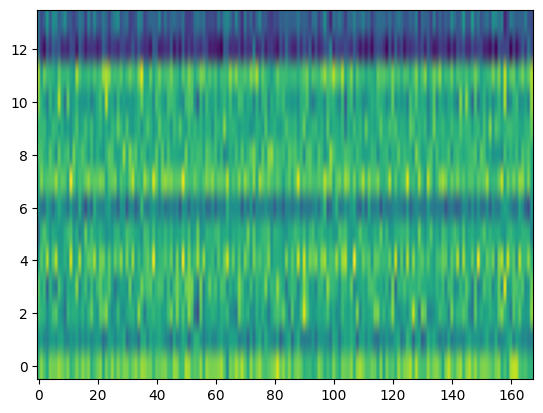

In [8]:
import matplotlib.pyplot as plt

plt.imshow(mu[0].detach().numpy(), aspect='auto', origin='lower', )